In [1]:
from SonicBatt import utils
import os
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
from mpl_toolkits.axes_grid1.inset_locator import (InsetPosition, mark_inset)
from matplotlib.ticker import FormatStrFormatter

root_dir = utils.root_dir()
study_path = os.path.join(root_dir, 'studies', 'degradation')
data_path = os.path.join(study_path, 'Raw Data')
visualistion_path = os.path.join(study_path, 'Visualisation')
database = pd.read_excel(os.path.join(data_path, 'database.xlsx'))
degr_tests = database.loc[database['test_type']=='degradation_exp2'].reset_index(drop=True)

cycles_completed = [int(i) for i in degr_tests['cycles_completed'].to_list()]
days_elapsed = degr_tests['days_elapsed'].to_list()
cycles_and_days = []
for i in range(len(cycles_completed)):
    cycles_and_days.append(
        '{} (day {})'.format(int(cycles_completed[i]), int(days_elapsed[i]))
        )

def colorscheme(n_increments, cmap='Blues'):
    return iter(
        mpl.colormaps[cmap](np.linspace(0.2, 1, n_increments))
    )

temp_colorsheme = ListedColormap(cm.Reds(np.linspace(0.2, 1, 256)))

# Plot font settings
ticksize=8
mpl.rc('xtick', labelsize=ticksize)
mpl.rc('ytick', labelsize=ticksize)
mpl.rc('axes', titlesize=12, labelsize=10) # --> labelsize also acts on colorbar label.
mpl.rc('legend', fontsize=8, title_fontsize=10)
mpl.rc('lines', linewidth=0.8, markersize=1)


In [2]:
# EIS
eis_TOC_dfs = []
eis_temperatures = []
eis_pre_ocvs = []
for i in range(len(degr_tests)):
    cell_id = degr_tests['cell_id'].iloc[i]
    test_id = degr_tests['test_id'].iloc[i]
    test_dir = os.path.join(data_path, test_id)
    Protocol_objects = utils.create_custom_object(test_id, test_dir)
    eis_TOC_dfs.append(Protocol_objects.EIS_other_seq.EIS_list[0].eis_df)
    previous_ind = Protocol_objects.EIS_other_seq.EIS_list[0].previous_ind
    # Obtain temperature at 'previous_ind' from cycling object
    parquet_filename = '{}_cycling.parquet'.format(test_id)
    parquet_filepath = os.path.join(data_path, test_id,parquet_filename)
    df_cycling = pq.read_table(parquet_filepath).to_pandas()
    eis_temperatures.append(
        df_cycling.loc[previous_ind, 'Temp(degC)'])
    eis_pre_ocvs.append(
        df_cycling.loc[previous_ind, 'V(V)'])


In [4]:
# %% Extract the Ohmic resistance and the charge transfer resistance
ohmic_resistances = []
Re_local_min = []
Re_local_min_ind = []
ct_resistances = []
for df_eis in eis_TOC_dfs:
    x = df_eis.loc[:, 'Zreal'].to_numpy()
    y = -df_eis.loc[:, 'Zimag'].to_numpy()
    ohmic_resistances.append(np.interp(0,y,x))
    #
    y_derivative= np.diff(y)
    y_derivative_reversed = y_derivative[::-1]
    for j, _ in enumerate(y_derivative_reversed):
        if ((y_derivative_reversed[j]>0) & (y_derivative_reversed[j+1]<0)):
            ind = len(y)-(j+1)
            Re_local_min.append((x[ind] + x[ind+1])/2)
            Re_local_min_ind.append(ind)
            break
ohmic_resistances = np.array(ohmic_resistances)
Re_local_min = np.array(Re_local_min)
ct_resistances = Re_local_min - ohmic_resistances

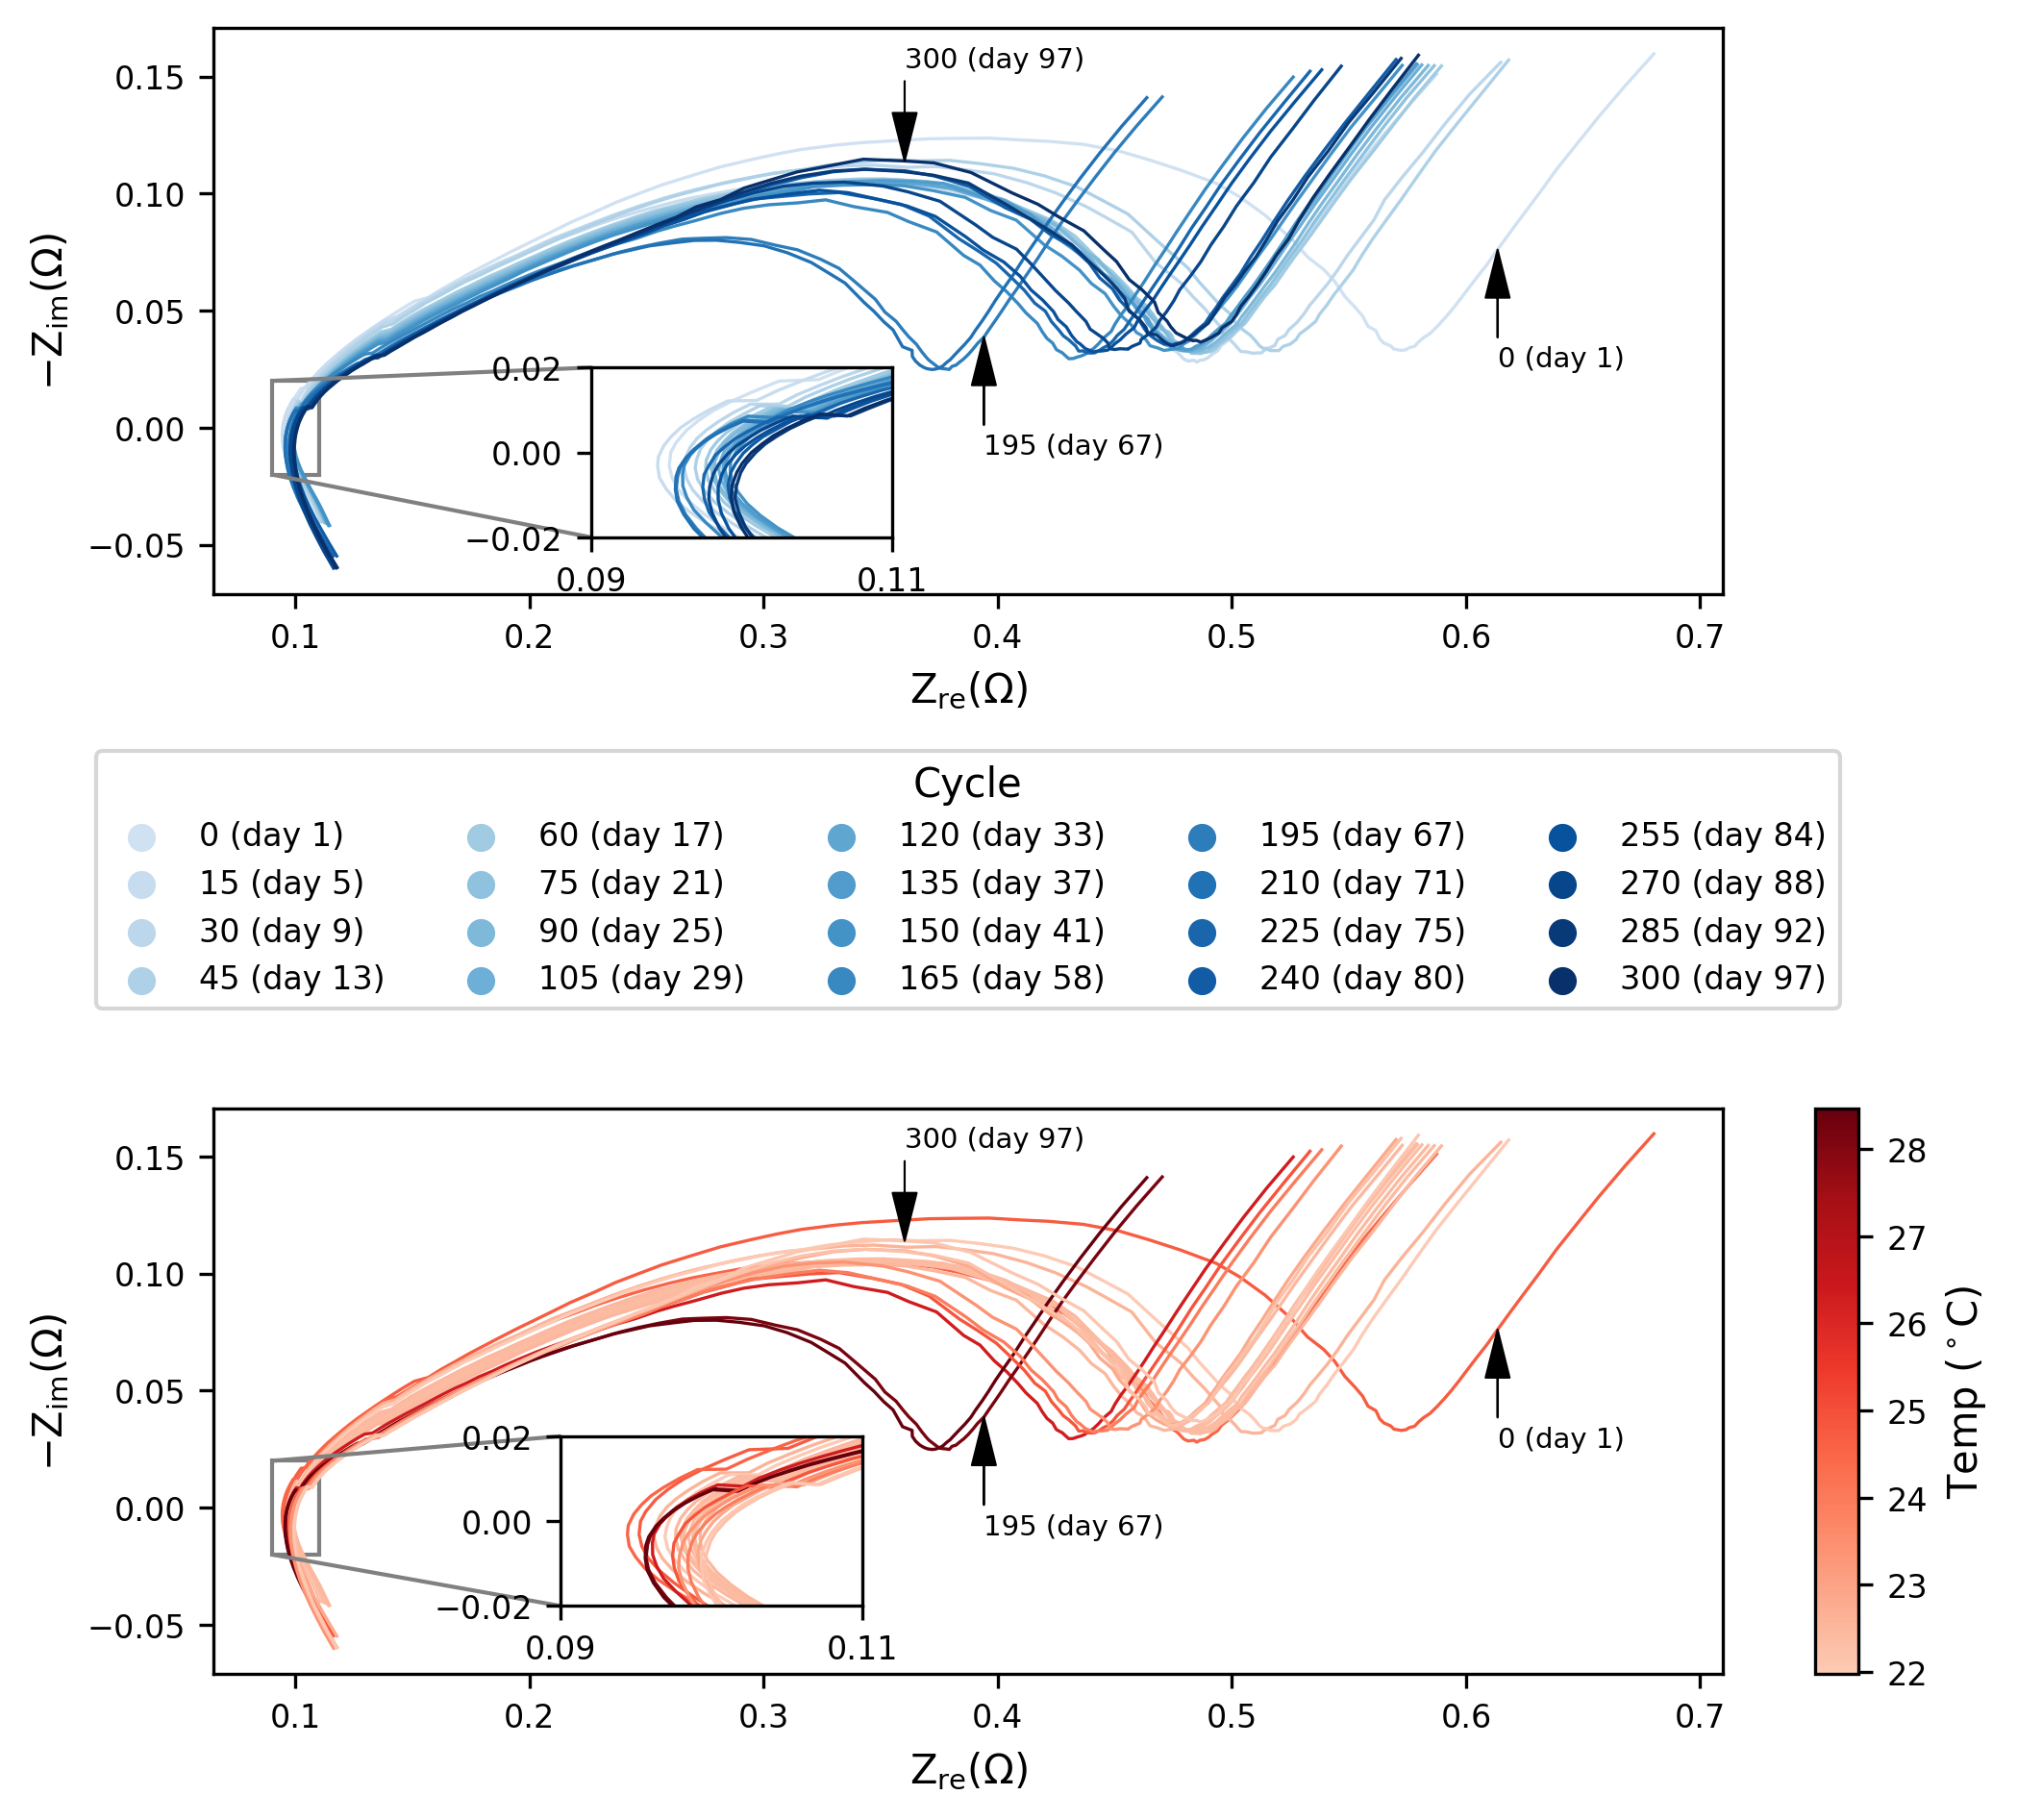

In [4]:
# Nyquist plots coloured by cycle and temperature
f, axs = plt.subplots(2,1, figsize=(7.5,8), dpi=300, constrained_layout=True,
             gridspec_kw={'hspace': 0.55})
# First axis: Colour by cycle
axins0 = plt.axes([0,0,1,1])
axins1 = plt.axes([0,0,1,1])
color_cycles = colorscheme(len(degr_tests))
norm = mpl.colors.Normalize(
    vmin=min(eis_temperatures), vmax=max(eis_temperatures))
for i, df_eis in enumerate(eis_TOC_dfs):
    # Create colours
    c_cycle = next(color_cycles)
    temperature = eis_temperatures[i]
    c_temp = temp_colorsheme(norm(temperature))
    #
    x = df_eis.loc[:, 'Zreal'].to_numpy()
    y = -df_eis.loc[:, 'Zimag'].to_numpy()
    label = cycles_and_days[i]
    axs[0].plot(x,y, c=c_cycle)
    axs[0].scatter([],[], color=c_cycle, label=label)
    axins0.plot(x,y, c=c_cycle)
    axs[1].plot(x,y, c=c_temp, label=label)
    axins1.plot(x,y, c=c_temp)

    # ------------------------
    # If you want to see charge transfer resistance right-most point:
    # axs[0].scatter(x[Re_local_min_ind[i]], y[Re_local_min_ind[i]], marker='*', c='k', s=10)
    # ------------------------
    
    # Annotate some points
    if i in [0, 12, 19]:
        vertical_shift = {0:-0.05, 12:-0.05, 19:0.04}
        point = {0:-9, 12:-15, 19:-40}
        x_annot = x[point[i]]
        y_annot = y[point[i]]
        annotation_args = {'text': label, 'xy': (x_annot,y_annot),
            'xytext':(x_annot,y_annot+vertical_shift[i]), 'fontsize': 7, 'ha': 'left',
            'arrowprops': dict(facecolor='black', width=0.02, headwidth=6, linewidth=0.5)}        
        axs[0].annotate(**annotation_args)
        axs[1].annotate(**annotation_args)
# Make sure x and y scales are equal
axs[0].set_aspect('equal', adjustable='box')
axs[1].set_aspect('equal', adjustable='box')
#
axs[0].set_xlabel('$\mathrm{Z_{re} (\Omega)}$')
axs[0].set_ylabel('$\mathrm{-Z_{im} (\Omega)}$')
axs[1].set_xlabel('$\mathrm{Z_{re} (\Omega)}$')
axs[1].set_ylabel('$\mathrm{-Z_{im} (\Omega)}$')

# Shrink current axis 1 height by 10% on the bottom
box = axs[0].get_position()
axs[0].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
# Put a legend below current axis
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), title="Cycle", ncol=5,
              markerscale=6)

# ------Position insets
# Axis 0
ip = InsetPosition(axs[0], [0.25,0.1,0.2,0.3])
axins0.set_axes_locator(ip)
mark_inset(axs[0], axins0, loc1=2, loc2=3, fc="none", ec='0.5')
# sub region of the original image
x1, x2, y1, y2 = 0.092, 0.105, -0.02, 0.02
axins0.set_xlim(x1, x2)
axins0.set_ylim(y1, y2)
axins0.set_xticks([0.09, 0.11])
# Axis 1
ip = InsetPosition(axs[1], [0.23,0.12,0.2,0.3])
axins1.set_axes_locator(ip)
mark_inset(axs[1], axins1, loc1=2, loc2=3, fc="none", ec='0.5')
# sub region of the original image
x1, x2, y1, y2 = 0.092, 0.105, -0.02, 0.02
axins1.set_xlim(x1, x2)
axins1.set_ylim(y1, y2)
axins1.set_xticks([0.09, 0.11])
#-------
# Shrink axis 1 height by 10% at the bottom
box = axs[1].get_position()
axs[1].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
# create color bar
box = axs[1].get_position()
axColor = plt.axes([box.x0*1.05 + box.width * 1.05, box.y0, 0.02, box.height])
cb = f.colorbar(cm.ScalarMappable(norm=norm, cmap=temp_colorsheme), ax = axs[1],
            cax = axColor) #location='right'
cb.set_label(label='Temp ($^\circ$C)')

save_filename = 'Exp2_eis'
utils.save_figure(f, visualistion_path, save_filename, 'pdf')


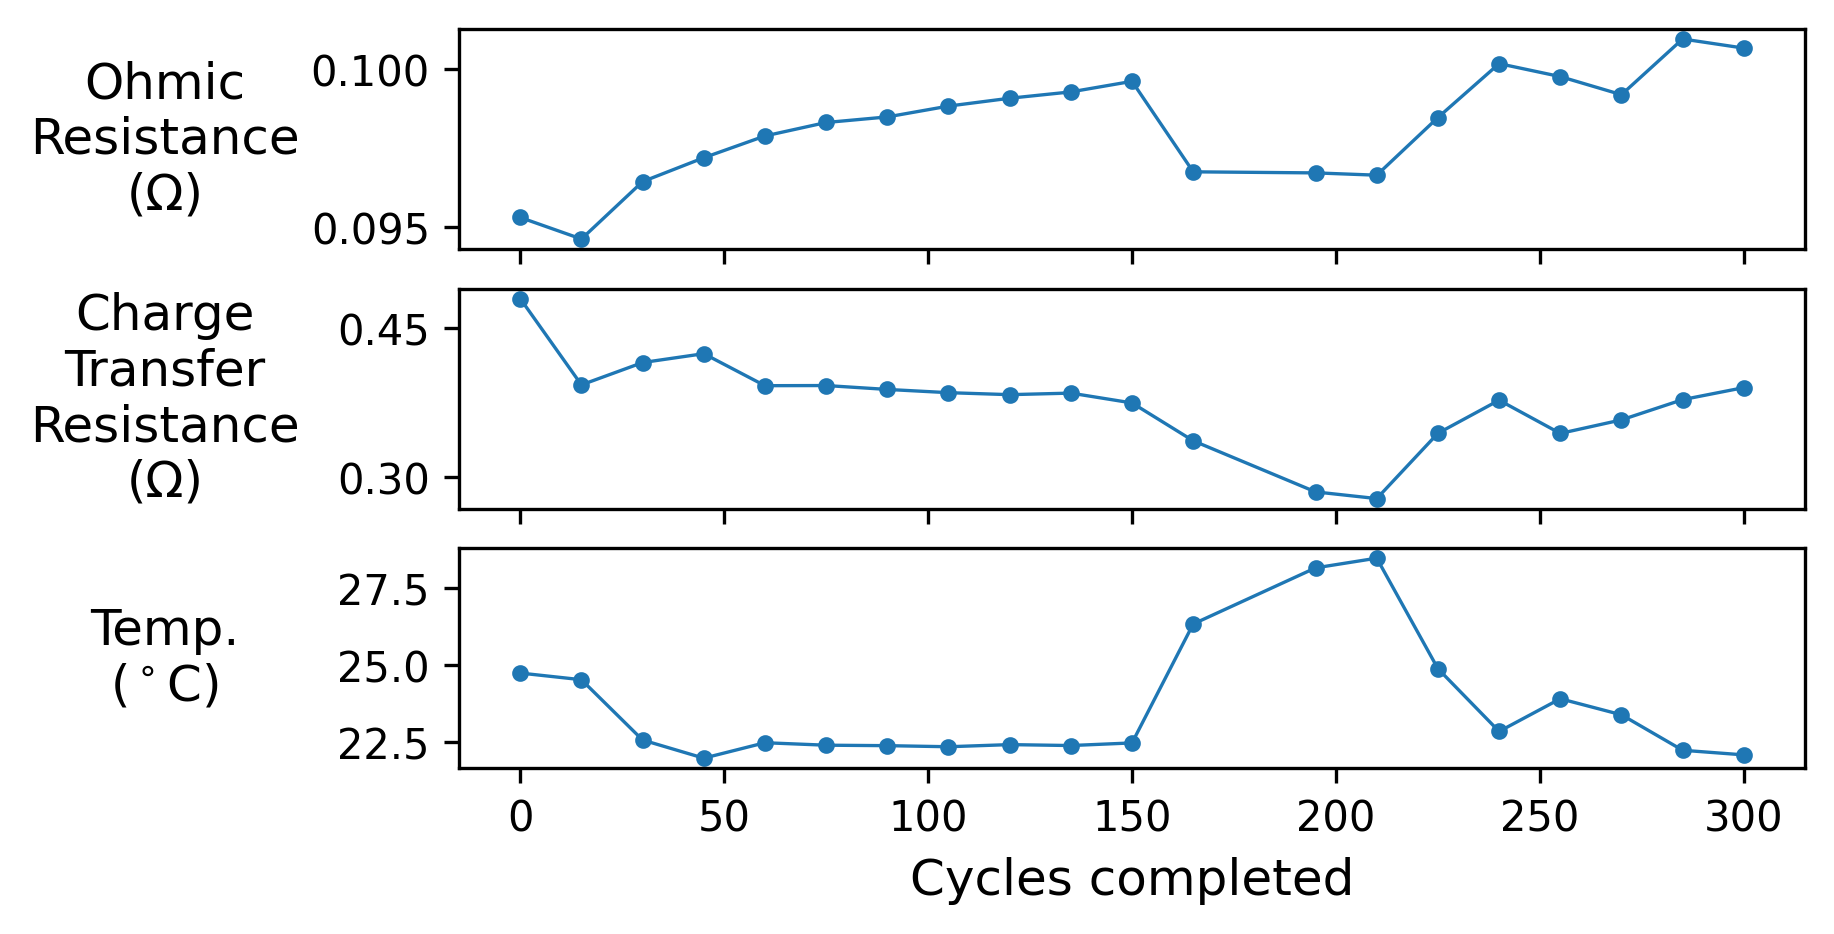

In [53]:
mpl.rc('axes', titlesize=12, labelsize=12)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)

scaler = 1
f, axs = plt.subplots(3, 1, figsize=(6*scaler, 3.0*scaler), dpi=300, sharex=True, sharey=False, constrained_layout=True)

# Ohmic resistances
axs[0].plot(cycles_completed, ohmic_resistances, color='tab:blue', marker='o', markersize=3)

# CT resistances
axs[1].plot(cycles_completed, ct_resistances, color='tab:blue', marker='o', markersize=3)

# Temperature
axs[2].plot(cycles_completed, eis_temperatures, color='tab:blue', marker='o', markersize=3)

axs[-1].set_xlabel('Cycles completed')
axs[0].set_ylabel('Ohmic\nResistance\n(Ω)', rotation=0, labelpad=35, va='center')
axs[1].set_ylabel('Charge\nTransfer\nResistance\n(Ω)', rotation=0, labelpad=35, va='center')
axs[2].set_ylabel('Temp.\n($^\circ$C)', rotation=0, labelpad=35, va='center')
axs[0].set_yticks([0.095, 0.100])
axs[1].set_yticks([0.30, 0.45])
f.align_ylabels()

save_filename = 'Exp2_eis_decomposition'
utils.save_figure(f, visualistion_path, save_filename, 'pdf')

mpl.rc('axes', titlesize=12, labelsize=10)
mpl.rc('xtick', labelsize=ticksize)
mpl.rc('ytick', labelsize=ticksize)

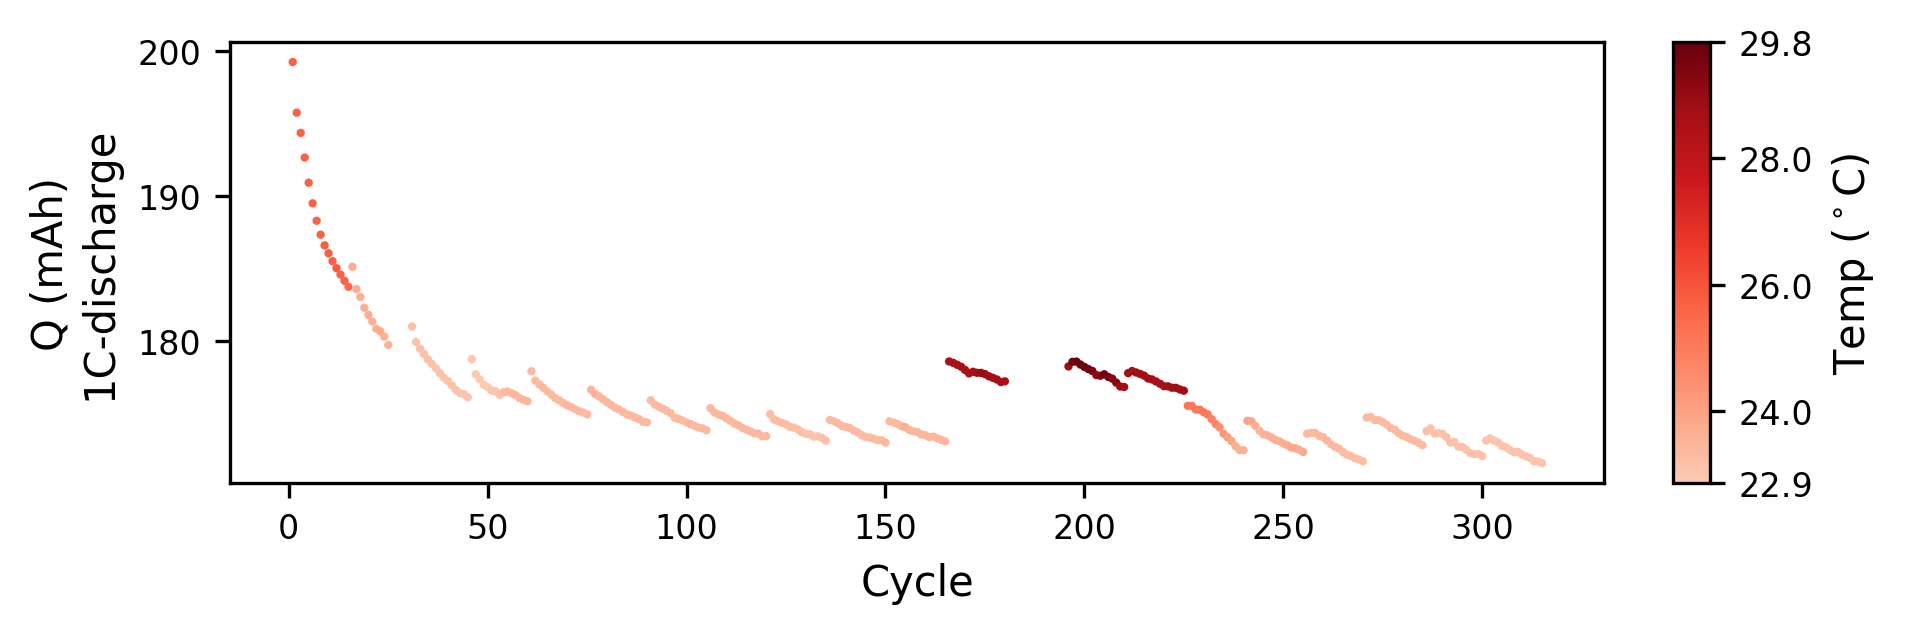

In [6]:
# Capacity fade (Discharge - at the rate of 1C)
discharge_steps_1c = range(67, 124, 3)
capacities_1c = []
temperatures_1c = []
cycles = []
for i in range(len(degr_tests)):
    test_id = degr_tests['test_id'].iloc[i]
    cycles_starting = degr_tests['cycles_completed'].iloc[i]
    parquet_filename = '{}_cycling.parquet'.format(test_id)
    parquet_filepath = os.path.join(data_path, test_id,parquet_filename)
    df_cycling = pq.read_table(parquet_filepath).to_pandas()
    max_step = df_cycling['Step'].max()
    count = 1
    for step in range(67,max_step, 3):
        if step in discharge_steps_1c: # just a sanity check
            filter = df_cycling['Step'] == step
            temp_df = df_cycling.loc[filter]
            capacities_1c.append(
                temp_df.loc[:, 'Q(mAh)'].max() - temp_df.loc[:, 'Q(mAh)'].min())
            temperatures_1c.append(
                temp_df.loc[:, 'Temp(degC)'].mean()
            )
            cycles.append(cycles_starting + count)
            count += 1

norm = mpl.colors.Normalize(
    vmin=min(temperatures_1c), vmax=max(temperatures_1c))
c = temp_colorsheme(norm(temperatures_1c))
f, ax = plt.subplots(1,1, figsize=(6.25,2), dpi=300, constrained_layout=True)
ax.scatter(cycles, capacities_1c, c=c, s=1)
ax.set_xlabel('Cycle')
ax.set_ylabel('Q (mAh)\n1C-discharge')
cb = f.colorbar(cm.ScalarMappable(norm=norm, cmap=temp_colorsheme), ax =ax, 
            location='right', aspect=12, #shrink=0.5,
            ticks=[min(temperatures_1c), 24, 26, 28, max(temperatures_1c)],
            format = FormatStrFormatter("%.1f"))
cb.set_label(label='Temp ($^\circ$C)')

save_filename = 'Exp2_Qfade'
utils.save_figure(f, visualistion_path, save_filename, 'png')
